In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_dir = "./data/kaggle-kakr-housing-data/data"

train_data_path = join(data_dir, "train.csv")
test_data_path = join(data_dir, "test.csv")

train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

In [3]:
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [4]:
train["date"] = train["date"].apply(lambda i : i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [5]:
y = train["price"]
del train["price"]
del train["id"]
print(train.columns)
print(y)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')
0         221900.0
1         180000.0
2         510000.0
3         257500.0
4         291850.0
           ...    
15030     610685.0
15031    1007500.0
15032     360000.0
15033     400000.0
15034     325000.0
Name: price, Length: 15035, dtype: float64


In [6]:
test["date"] = test["date"].apply(lambda i: i[:6]).astype(int)

del test["id"]
test.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

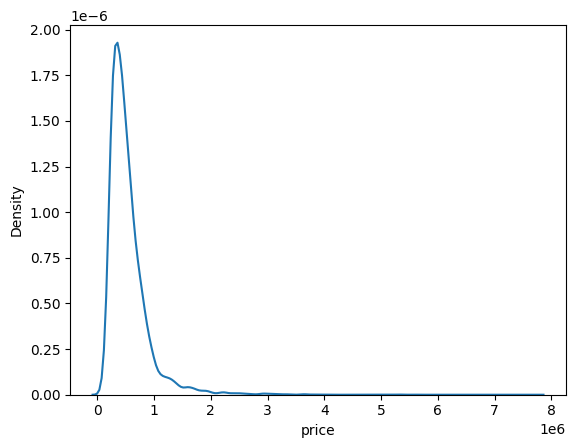

In [7]:
sns.kdeplot(y)
plt.show()

In [8]:
# 나중에 모델이 값을 예측한 후 다시 np.explm1()로 원래의 스케일로 돌려야 함
y = np.log1p(y)

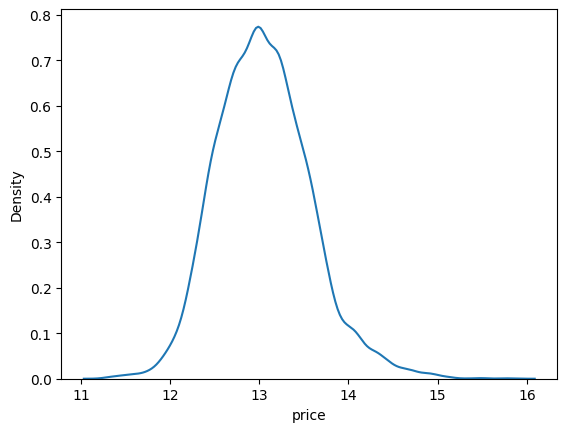

In [9]:
sns.kdeplot(y)
plt.show()

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15035 entries, 0 to 15034
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           15035 non-null  int64  
 1   bedrooms       15035 non-null  int64  
 2   bathrooms      15035 non-null  float64
 3   sqft_living    15035 non-null  int64  
 4   sqft_lot       15035 non-null  int64  
 5   floors         15035 non-null  float64
 6   waterfront     15035 non-null  int64  
 7   view           15035 non-null  int64  
 8   condition      15035 non-null  int64  
 9   grade          15035 non-null  int64  
 10  sqft_above     15035 non-null  int64  
 11  sqft_basement  15035 non-null  int64  
 12  yr_built       15035 non-null  int64  
 13  yr_renovated   15035 non-null  int64  
 14  zipcode        15035 non-null  int64  
 15  lat            15035 non-null  float64
 16  long           15035 non-null  float64
 17  sqft_living15  15035 non-null  int64  
 18  sqft_l

In [11]:
train.isnull().any()

date             False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
lat              False
long             False
sqft_living15    False
sqft_lot15       False
dtype: bool

In [12]:
for col in train.columns:
    unique_vals = train[col].nunique()
    if unique_vals < 20:  
        print(f"{col}: categorical")
    else:
        print(f"{col}: numerical")

date: categorical
bedrooms: categorical
bathrooms: numerical
sqft_living: numerical
sqft_lot: numerical
floors: categorical
waterfront: categorical
view: categorical
condition: categorical
grade: categorical
sqft_above: numerical
sqft_basement: numerical
yr_built: numerical
yr_renovated: numerical
zipcode: numerical
lat: numerical
long: numerical
sqft_living15: numerical
sqft_lot15: numerical


생각해보니 컬럼의 개수가 적다고 범주형데이터로 간주하고 원핫인코딩하면 안됨...  
값의 크기가 의미가 있기 때문...  
따라서 원핫인코딩 진행 X

In [13]:
train[train.duplicated()==True]

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15


In [14]:
import numpy as np

def count_outliers_zscore(data, threshold=3):
    # 수치형 데이터만 이상치 탐색
    numeric_cols = data.columns

    for col in numeric_cols:
        z_scores = ((data[col] - data[col].mean()) / data[col].std()).abs()
        count = (z_scores > threshold).sum()
        print(f"{col} 이상치 : {count}개")

count_zscore_outliers = count_outliers_zscore(train)

date 이상치 : 0개
bedrooms 이상치 : 43개
bathrooms 이상치 : 123개
sqft_living 이상치 : 174개
sqft_lot 이상치 : 244개
floors 이상치 : 4개
waterfront 이상치 : 107개
view 이상치 : 581개
condition 이상치 : 21개
grade 이상치 : 96개
sqft_above 이상치 : 173개
sqft_basement 이상치 : 168개
yr_built 이상치 : 0개
yr_renovated 이상치 : 631개
zipcode 이상치 : 0개
lat 이상치 : 0개
long 이상치 : 169개
sqft_living15 이상치 : 164개
sqft_lot15 이상치 : 254개


In [15]:
def count_outliers_iqr(data):
    # 수치형 데이터만 이상치 탐색
    numeric_cols = data.columns

    for col in numeric_cols:
        Q1 = data[col].quantile(0.25)
        Q3 = data[col].quantile(0.75)
        IQR = Q3-Q1
        lower = Q1 - 1.5*IQR
        upper = Q3 + 1.5*IQR
        count = ((data[col] < lower) | (data[col] > upper)).sum()
        print(f"{col} 이상치 : {count}개")

count_outliers_iqr(train)

date 이상치 : 0개
bedrooms 이상치 : 364개
bathrooms 이상치 : 395개
sqft_living 이상치 : 386개
sqft_lot 이상치 : 1697개
floors 이상치 : 0개
waterfront 이상치 : 107개
view 이상치 : 1487개
condition 이상치 : 21개
grade 이상치 : 1339개
sqft_above 이상치 : 395개
sqft_basement 이상치 : 401개
yr_built 이상치 : 0개
yr_renovated 이상치 : 631개
zipcode 이상치 : 0개
lat 이상치 : 2개
long 이상치 : 186개
sqft_living15 이상치 : 397개
sqft_lot15 이상치 : 1546개


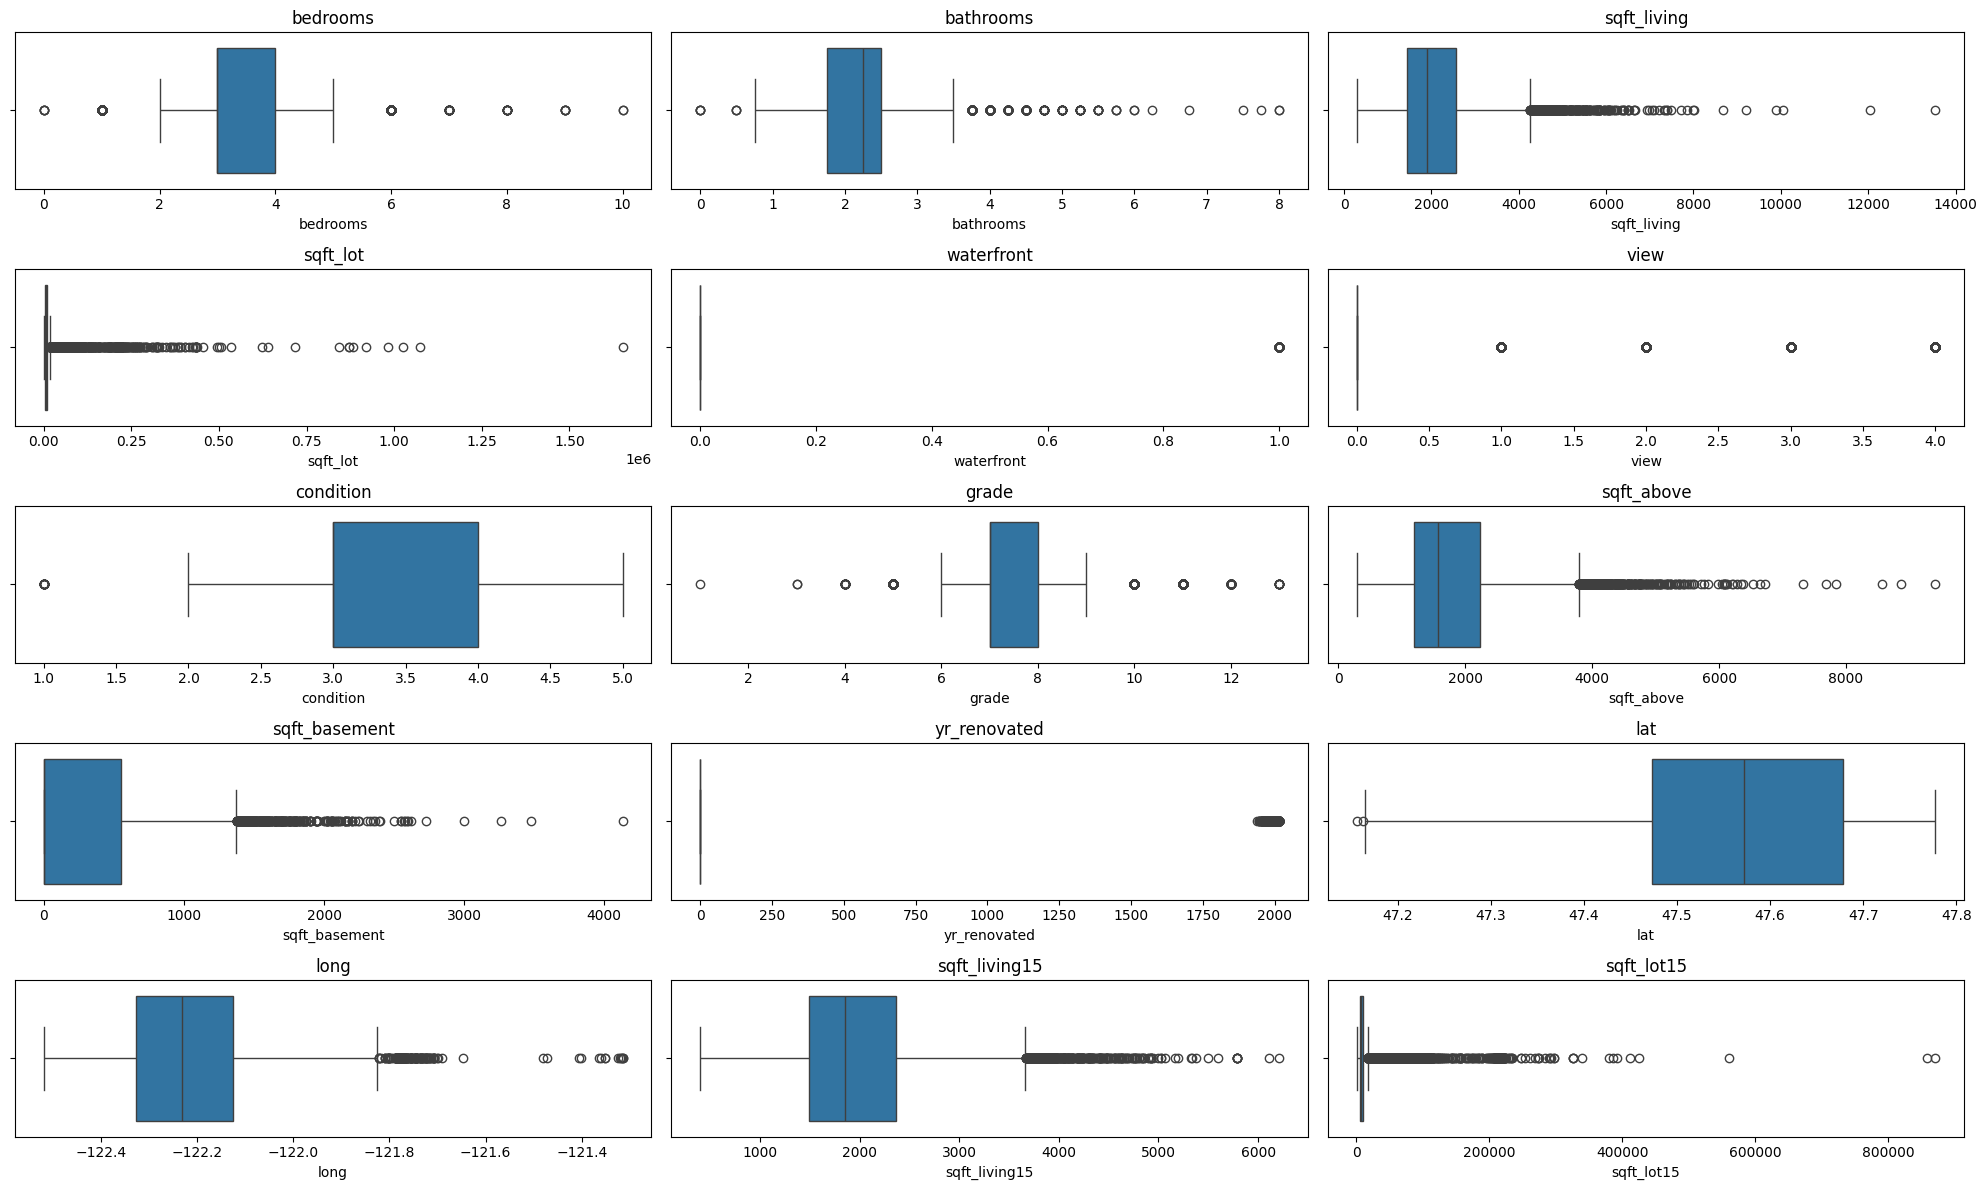

In [16]:
outlier_cols = ["bedrooms", "bathrooms", "sqft_living", "sqft_lot",
                "waterfront", "view", "condition", "grade",
                "sqft_above", "sqft_basement", "yr_renovated",
                "lat", "long", "sqft_living15", "sqft_lot15"]

fig, axes = plt.subplots(5, 3, figsize=(20, 12))
axes = axes.flatten()
for i, col in enumerate(outlier_cols):
    sns.boxplot(x=train[col], ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

이상치가 과하면 삭제하려고 했는데, 각 컬럼별 설명을 읽어보니, 이상치에 대한 처리를 하지 않아도 될 것 같다.  
예를 들어 bedroom은 부자집이면 10개 이상 있을 수 있고, bathroom도 마찮가지이다.  
sqft가 앞에 붙은 컬럼은 평방 피트(면적)을 의미하는데, 부자집이면 집의 면적이 매우 큰 것도 이해가 된다.

In [17]:
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [18]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [19]:
random_state=2020

In [20]:
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]

In [21]:
from sklearn.model_selection import train_test_split

"""
get_scores
모델 학습 및 예측 진행 후 
"""

def get_scores(models, train, y):
    df = {}
    X_train, X_test, y_train, y_test = train_test_split(
        train, y, random_state=random_state, test_size=0.2
    )

    for model in models:
        model_name = model.__class__.__name__

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)

    return score_df

In [22]:
# 하이퍼파라미터 지정없이 디폴트 값으로 각 모델에 대한 성능 비교
get_scores(models, train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000517 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


,RMSE
GradientBoostingRegressor,128360.196497
RandomForestRegressor,125426.500842
XGBRegressor,117618.223289
LGBMRegressor,111920.367359


하이퍼파라미터 수정 없이 각 모델에 대한 score를 계산했을 때는 LGBM이 가장 좋음

그리드 탐색 진행  
각 모델(gbm, xgb, lgbm, rdf)에 대한 하이퍼 파리미터 탐색

In [23]:
from sklearn.model_selection import GridSearchCV
"""
GridSearchCV(estimator, param_grid, scoring=None, cv=None, n_jobs=None)
- 동작 수행 : 주어진 하이퍼파라미터 후보 집합(param_grid)에서 최적 조합을 탐색
- estimator : 학습할 모델 객체 (예: LinearRegression(), SVC())
- param_grid : 탐색할 하이퍼파라미터 dict (예: {'C':[0.1,1,10], 'kernel':['linear','rbf']})
- scoring(kword) : 모델 성능을 평가할 방법 (예: 'accuracy', 'neg_mean_squared_error')
- cv(kword) : 교차 검증 분할 수 또는 전략 (예: 5 → 5-겹 교차검증)
- n_jobs(kword) : 병렬 처리에 사용할 CPU 코어 수 (None=1, -1=모든 코어)
"""

"""
1. GridSearchCV 모델로 `model`을 초기화합니다.
2. 모델을 fitting 합니다.
3. params, score에 각 조합에 대한 결과를 저장합니다.
4. 데이터 프레임을 생성하고, RMSLE 값을 추가한 후 점수가 높은 순서로 정렬한 `results`를 반환합니다.
"""
# 교차 검증을 위해 분할할 데이터 개수는 5로 고정
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(
        model, param_grid=param_grid, scoring="neg_mean_squared_error",
        cv=5, verbose=verbose, n_jobs=n_jobs
    )

    grid_model.fit(train, y)

    params = grid_model.cv_results_["params"]
    score = grid_model.cv_results_["mean_test_score"]

    results = pd.DataFrame(params)
    results["score"] = score

    results["RMSLE"] = np.sqrt(-1 * results["score"])
    results = results.sort_values("RMSLE")

    return results

my_GridSearch()로 각 모델에 적절한 하이퍼파라미터 값을 탐색하고,  
하이퍼파라미터를 적용한 모델을 get_scores()를 통해 RMSE를 구함  
  
여러 모델들에 대하여 위 과정을 반복하고 가장 낮은 RMSE를 가진 모델로 submission파일 작성

In [24]:
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [1, 10],
}

model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,max_depth,n_estimators,score,RMSLE
3,10,100,-0.027027,0.164399
2,10,50,-0.029177,0.170814
1,1,100,-0.055020,0.234564
0,1,50,-0.073394,0.270914


In [25]:
# 가장 좋은 성능을 가지는 하이퍼파라미터 값 집어넣고 get_scores 돌려보기
lgbm_model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
get_scores([lgbm_model], train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


,RMSE
LGBMRegressor,112243.78584


놀랍게도 하이퍼파라미터를 노드에 나온대로 수정하고 get_score진행하니 오히려 더 낮은 점수가 나옴...  
만약 RMSE가 낮게 나오는 하이퍼파라미터를 찾으면 바로 test데이터 넣고 prediction도출 예정

---

### 여기부터는 하이퍼파라미터 optimization...

In [26]:
param_grid = {
    "n_estimators": np.linspace(100, 1000, 3, dtype=int),
    "max_depth": [-1],
    "learning_rate": np.linspace(0.01, 0.1, 10),
    "num_leaves": np.linspace(31, 127, 10, dtype=int)
}
lgbm_model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


,learning_rate,max_depth,n_estimators,num_leaves,score,RMSLE
110,0.04,-1,1000,31,-0.025864,0.160824
160,0.06,-1,550,31,-0.025877,0.160863
100,0.04,-1,550,31,-0.025879,0.160871
80,0.03,-1,1000,31,-0.025931,0.161032
81,0.03,-1,1000,41,-0.025940,0.161059
...,...,...,...,...,...,...
4,0.01,-1,100,73,-0.074285,0.272554
3,0.01,-1,100,63,-0.075194,0.274216
2,0.01,-1,100,52,-0.076507,0.276598
1,0.01,-1,100,41,-0.078457,0.280101


사실 처음에 10000 fits 짜리 돌렸었는데 2시간 째 돌아가길래 멈추고 하이퍼파라미터 그리드 길이 줄인 다음에 다시 돌렸다...  
1500 fits 인데 약 32분이 걸렸다...  
근데 좀 욕심이 나는게.. n_estimators의 최대치를 1000으로 했는데, 1000일 때의 성능이 거의 대부분 좋은 것 같다.  
그래서 n_estimators를 늘려서 다시 해보고 싶다..

어쨋든 이제 RMSLE가 최소가 나온 하이퍼 파라미터 값들을 입력하여 get_score 해보자.

In [28]:
# 가장 좋은 성능을 가지는 하이퍼파라미터 값 집어넣고 get_scores 돌려보기
lgbm_model = LGBMRegressor(
    learning_rate=0.04, max_depth=-1, n_estimators=1000, 
    num_leaves=31, random_state=random_state
    )
get_scores([lgbm_model], train, y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000726 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info] Number of data points in the train set: 12028, number of used features: 19
[LightGBM] [Info] Start training from score 13.047779


,RMSE
LGBMRegressor,107777.788254


일단 성능은 훨씬 잘나왔다... 이제 이걸로 submit 해보자...

get_score()를 진행하면서 모델을 학습시키긴 하는데, 해당 함수 안에서는 train데이터를 다시 또 train과 test로 나누어 학습하기 때문에, 온전한 train데이터로 다시 학습시켜야 함  
따라서 아래 코드에서 모델을 새로 초기화하고 학습 진행

In [35]:
lgbm_model = LGBMRegressor(
    learning_rate=0.04, max_depth=-1, n_estimators=1000, 
    num_leaves=31, random_state=random_state
    )
lgbm_model.fit(train, y)
prediction = lgbm_model.predict(test)

# prediction의 scale 복구
prediction = np.expm1(prediction)
prediction

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2338
[LightGBM] [Info] Number of data points in the train set: 15035, number of used features: 19
[LightGBM] [Info] Start training from score 13.048122


array([ 513605.5544479 ,  487798.6675573 , 1318282.65712681, ...,
        487685.00068184,  339992.43273599,  433177.00762142],
      shape=(6468,))

제출하기 전에 sample_submission 파일과 내 prediction의 형태 비교

In [38]:
sample_submission_path = join(data_dir, "sample_submission.csv")
sample_sub = pd.read_csv(sample_submission_path)
sample_sub.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


sample_sub의 price column을 내 prediction으로 수정하여 넣으면 제출하면 될 것 같음

In [39]:
sub = sample_sub.copy()
sub['price'] = prediction
sub.head()

,id,price
0,15035,5.136056e+05
1,15036,4.877987e+05
2,15037,1.318283e+06
3,15038,3.047866e+05
4,15039,3.294618e+05


In [40]:
# 파일 이름에 실수부분은 해당 모델의 RMSLE값을 넣은 것임
submission_csv_path = '{}/submission_{}_RMSLE_{}.csv'.format(data_dir, 'lgbm', '0.160824')
sub.to_csv(submission_csv_path, index=False)
print(submission_csv_path)

./data/kaggle-kakr-housing-data/data/submission_lgbm_RMSLE_0.160824.csv
